v2.

# Photometric Redshift Estimation

We will try to estimate the redshift from **DES** data using the match from the VVDS.

We use Machine Learning methods and Deep learning methods


In [52]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    print("Baixando Funções que serão usadas nesse notebook")
    ! shred -u astroFunctions.py
    ! wget https://raw.githubusercontent.com/zxcorr/zxcorr_DataAccess/main/DESzxcorr/pycode/astroFunctions.py -O astroFunctions.py
    ! wget
    ! pip install esutil
    ! pip install healpy
    import astroFunctions as astro
    from google.colab import drive
    drive.mount('/content/drive')
else:
    import sys,os
    home = os.getenv("HOME")
    sys.path.append(home+"/Projetos/PHOTOzxcorr/functions/") # user here the path where we download the folder DESzxcoorr
    
    

## Import Libraries

In [2]:
import logging 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import healpy as hp
import os,sys
import matplotlib
from astropy.io import ascii 
from astropy.table import Table
import seaborn as sns
import time

# Regression Libraries
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor,AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
import xgboost as xgb
import lightgbm as lgb



# Other Libraries
from sklearn.decomposition import PCA
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler,RobustScaler
import category_encoders as ce
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score, KFold, train_test_split,ShuffleSplit
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import norm, skew #for some statistics


# Neural Network Libs
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization,Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from sklearn.metrics import confusion_matrix
import keras as ks
%matplotlib inline

## Functions

Some functions that it's importants

In [3]:
def clean_tab(tab,col,val):
    tab.drop(tab[tab[col]==val].index,inplace = True)
def tts_split(X,y,size):
    rs = ShuffleSplit(n_splits=5, test_size=size, random_state=0)
    rs.get_n_splits(X)
    for train_index, test_index in rs.split(X, y): 
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    return X_train, X_test,y_train, y_test

n_folds = 5

def rmsle_cv(model,X_train,y_train):
    kf = KFold(5, shuffle=True, random_state=None).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train.ravel(), scoring="neg_mean_squared_error", cv = kf))
    return(rmse)
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))
def rmse_ann(y_true, y_pred):
    return ks.backend.sqrt(ks.backend.mean(ks.backend.square(y_pred - y_true), axis=-1))
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([0,1])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
               label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
               label = 'Val Error')
    plt.ylim([0,1])
    plt.legend()
    plt.show()




## Load the Data

In [111]:
if IN_COLAB:
    path1 = "/content/drive/Shareddrives/Optical Data/DES Data/match-des-ps2"
    path2 = "/content/drive/Shareddrives/Optical Data/DES Data/results/PSPixelFit_PS1_VIPERS_VVDS"
    path3 = "/content/drive/Shareddrives/Optical Data/DES Data/64"
else:
    path1 = home+"/Projetos/PHOTOzxcorr/data/des_vvds"
    path2 = home+"/Projetos/PHOTOzxcorr/data/vvds"

In [112]:
filename1 = os.listdir(path1)
filename2 = os.listdir(path2)
#filename3 = os.listdir(path3)

In [113]:
l1 = []
for i in range(len(filename1)): # if breaks, its the RAM so read less data.
    path_dir = os.path.join(path1,filename1[i])
    df = Table.read(path_dir).to_pandas()
    l1.append(df)
des = pd.concat(l1, axis=0, ignore_index=True)
del df,l1

l1 = []
for i in range(len(filename2)): # if breaks, its the RAM so read less data.
    path_dir = os.path.join(path2,filename2[i])
    df = Table.read(path_dir).to_pandas()
    l1.append(df)
vvds = pd.concat(l1, axis=0, ignore_index=True)
del df,l1

#l1= []
#for i in range(len(filename2)): # if breaks, its the RAM so read less data.
#    path_dir = os.path.join(path2,filename2[i])
#    df = Table.read(path_dir).to_pandas()
#    l1.append(df)
#ps = pd.concat(l1, axis=0, ignore_index=True)
#del df,l1

In [114]:
des.head()

COADD_OBJECT_ID         TILENAME  HPIX_32  HPIX_64  HPIX_1024  HPIX_4096  \
0        104665233  b'DES0219-0541'     4422    17689    4528640   72458240   
1        110140506  b'DES0221-0416'     4422    17689    4528622   72457966   
2        110141276  b'DES0221-0416'     4422    17689    4528622   72457962   
3        110141600  b'DES0221-0416'     4422    17689    4528622   72457960   
4        110142890  b'DES0221-0416'     4422    17689    4528619   72457914   

   HPIX_16384         RA       DEC  ALPHAWIN_J2000  ...  SPREADERR_MODEL_G  \
0  1159331840  34.452509 -5.376883       34.452509  ...           0.000934   
1  1159327464  35.623279 -4.388962       35.623279  ...           0.012087   
2  1159327404  35.608125 -4.404374       35.608125  ...           0.009313   
3  1159327371  35.612266 -4.411218       35.612266  ...           0.006501   
4  1159326638  35.560879 -4.440139       35.560879  ...           0.000440   

   SPREADERR_MODEL_R  SPREADERR_MODEL_I  SPREADERR_MODEL_Z  SPREADERR_MODEL_Y  \
0           0.000562           0.000566           0.000829           0.002365   
1           0.003399           0.002264           0.002455           0.006365   
2           0.006066           0.004834           0.006624           0.014340   
3           0.003061           0.001976           0.002048           0.004460   
4           0.001246           0.001589           0.002014           0.004566   

   WAVG_SPREADERR_MODEL_G  WAVG_SPREADERR_MODEL_R  WAVG_SPREADERR_MODEL_I  \
0                 0.00192                0.000748                0.001186   
1               -99.00000              -99.000000                0.002392   
2               -99.00000              -99.000000              -99.000000   
3               -99.00000                0.006813                0.001997   
4               -99.00000              -99.000000              -99.000000   

   WAVG_SPREADERR_MODEL_Z  WAVG_SPREADERR_MODEL_Y  
0                0.001678                0.002032  
1                0.002708              -99.000000  
2              -99.000000              -99.000000  
3                0.002202              -99.000000  
4              -99.000000              -99.000000  

[5 rows x 213 columns]

In [115]:
des.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163350 entries, 0 to 163349
Columns: 213 entries, COADD_OBJECT_ID to WAVG_SPREADERR_MODEL_Y
dtypes: float64(181), int64(31), object(1)
memory usage: 265.5+ MB


In [116]:
des.describe()

COADD_OBJECT_ID        HPIX_32        HPIX_64     HPIX_1024  \
count     1.633500e+05  163350.000000  163350.000000  1.633500e+05   
mean      2.092855e+08    6101.555476   24407.900380  6.248550e+06   
std       1.197361e+08    2201.373192    8805.736368  2.254269e+06   
min       1.046652e+08    4420.000000   17683.000000  4.526848e+06   
25%       1.174796e+08    4421.000000   17686.000000  4.527762e+06   
50%       1.189020e+08    4423.000000   17692.000000  4.529193e+06   
75%       3.643316e+08    8983.000000   35935.000000  9.199527e+06   
max       3.703735e+08    8989.000000   35957.000000  9.205247e+06   

          HPIX_4096    HPIX_16384             RA            DEC  \
count  1.633500e+05  1.633500e+05  163350.000000  163350.000000   
mean   9.997681e+07  1.599629e+09      42.635446     -13.185605   
std    3.606830e+07  5.770928e+08       7.995037      11.020984   
min    7.242957e+07  1.158873e+09      34.452509     -28.616850   
25%    7.244420e+07  1.159107e+09      36.386004     -27.377954   
50%    7.246709e+07  1.159473e+09      37.035594      -5.191638   
75%    1.471924e+08  2.355079e+09      52.835624      -4.658498   
max    1.472840e+08  2.356543e+09      54.135857      -3.587948   

       ALPHAWIN_J2000  DELTAWIN_J2000  ...  SPREADERR_MODEL_G  \
count   163350.000000   163350.000000  ...       1.633500e+05   
mean        42.635446      -13.185605  ...       2.279510e+01   
std          7.995037       11.020984  ...       7.276598e+03   
min         34.452509      -28.616850  ...       0.000000e+00   
25%         36.386003      -27.377954  ...       2.256399e-03   
50%         37.035594       -5.191638  ...       4.074190e-03   
75%         52.835624       -4.658498  ...       6.467353e-03   
max         54.135857       -3.587948  ...       2.873334e+06   

       SPREADERR_MODEL_R  SPREADERR_MODEL_I  SPREADERR_MODEL_Z  \
count      163350.000000      163350.000000      163350.000000   
mean            0.022745           0.003520           0.414989   
std             5.182623           0.002544          73.385282   
min             0.000000           0.000014           0.000000   
25%             0.001327           0.001479           0.002037   
50%             0.002690           0.002989           0.004134   
75%             0.004452           0.005097           0.006972   
max          1546.559570           0.032680       19221.845703   

       SPREADERR_MODEL_Y  WAVG_SPREADERR_MODEL_G  WAVG_SPREADERR_MODEL_R  \
count       1.633500e+05           163350.000000           163350.000000   
mean        1.706121e+03              -48.512487              -26.040607   
std         5.997045e+05               49.491753               43.590119   
min         0.000000e+00              -99.000000              -99.000000   
25%         6.331537e-03              -99.000000              -99.000000   
50%         1.180025e-02                0.000267                0.001362   
75%         1.820478e-02                0.002438                0.002780   
max         2.418781e+08                1.093628                0.640645   

       WAVG_SPREADERR_MODEL_I  WAVG_SPREADERR_MODEL_Z  WAVG_SPREADERR_MODEL_Y  
count           163350.000000           163350.000000           163350.000000  
mean               -29.513987              -43.611171              -81.097598  
std                 45.287936               49.150183               38.103917  
min                -99.000000              -99.000000              -99.000000  
25%                -99.000000              -99.000000              -99.000000  
50%                  0.001285                0.000671              -99.000000  
75%                  0.002761                0.002576              -99.000000  
max                  0.295300                0.356951                0.191141  

[8 rows x 212 columns]

In [117]:
vvds.head()

ID      RA_1     DEC_1       z  z_Err  flag        source comments  \
0  b'9071'  52.96853 -27.98808  0.3939 -9.999  b'3'  b'VVDS_CDFS'     b'-'   
1  b'9189'  53.03879 -27.98691  0.4480 -9.999  b'4'  b'VVDS_CDFS'     b'-'   
2  b'9322'  53.24749 -27.98711  1.0345 -9.999  b'3'  b'VVDS_CDFS'     b'-'   
3  b'9432'  53.28671 -27.98483  0.3467 -9.999  b'4'  b'VVDS_CDFS'     b'-'   
4  b'9596'  53.17321 -27.98280  0.7810 -9.999  b'4'  b'VVDS_CDFS'     b'-'   

   totobs  totexp  ...  SPREADERR_MODEL_I SPREADERR_MODEL_Z  \
0      -9      -9  ...           0.001762          0.002954   
1      -9      -9  ...           0.000752          0.001084   
2      -9      -9  ...           0.006349          0.006837   
3      -9      -9  ...           0.002163          0.003447   
4      -9      -9  ...           0.001486          0.002645   

   SPREADERR_MODEL_Y  WAVG_SPREADERR_MODEL_G  WAVG_SPREADERR_MODEL_R  \
0           0.009364                0.001520                0.001053   
1           0.004009                0.000939                0.000532   
2           0.020698              -99.000000              -99.000000   
3           0.018772                0.002183                0.001233   
4           0.007238                0.001894                0.001378   

   WAVG_SPREADERR_MODEL_I  WAVG_SPREADERR_MODEL_Z  WAVG_SPREADERR_MODEL_Y  \
0                0.001823                0.002879              -99.000000   
1                0.000764                0.001077                0.004233   
2              -99.000000              -99.000000              -99.000000   
3                0.002042                0.004088              -99.000000   
4                0.001549                0.002726              -99.000000   

     random  64_ring  
0  0.266798    36006  
1  0.617154    36006  
2  0.155856    36006  
3  0.747097    36006  
4  0.881641    36006  

[5 rows x 225 columns]

In [118]:
vvds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5332 entries, 0 to 5331
Columns: 225 entries, ID to 64_ring
dtypes: float32(2), float64(184), int32(2), int64(32), object(5)
memory usage: 9.1+ MB


In [119]:
originalTam = 5332

In [120]:
vvds.describe()

RA_1        DEC_1            z     z_Err  totobs  totexp  \
count  5332.000000  5332.000000  5332.000000  5332.000  5332.0  5332.0   
mean     46.222661   -18.058309     0.615411    -9.999    -9.0    -9.0   
std       8.130955    11.507764     0.280552     0.000     0.0     0.0   
min      36.261836   -27.988080     0.000000    -9.999    -9.0    -9.0   
25%      36.687031   -27.840360     0.415925    -9.999    -9.0    -9.0   
50%      53.001150   -27.700790     0.622400    -9.999    -9.0    -9.0   
75%      53.141290    -4.535002     0.768700    -9.999    -9.0    -9.0   
max      53.298710    -4.139604     3.607000    -9.999    -9.0    -9.0   

       COADD_OBJECT_ID      HPIX_32      HPIX_64     HPIX_1024  ...  \
count     5.332000e+03  5332.000000   5332.00000  5.332000e+03  ...   
mean      2.622898e+08  7075.901163  28305.44805  7.246325e+06  ...   
std       1.227174e+08  2249.864925   9000.69594  2.304227e+06  ...   
min       1.142332e+08  4420.000000  17683.00000  4.527102e+06  ...   
25%       1.174813e+08  4423.000000  17692.00000  4.529188e+06  ...   
50%       3.663214e+08  8983.000000  35935.00000  9.199518e+06  ...   
75%       3.663296e+08  8983.000000  35935.00000  9.199543e+06  ...   
max       3.663375e+08  8989.000000  35957.00000  9.205014e+06  ...   

       SPREADERR_MODEL_I  SPREADERR_MODEL_Z  SPREADERR_MODEL_Y  \
count        5332.000000        5332.000000        5332.000000   
mean            0.002613           0.004138           0.261648   
std             0.001899           0.013971           9.561648   
min             0.000083           0.000095           0.000299   
25%             0.001139           0.001621           0.005531   
50%             0.002217           0.003263           0.010165   
75%             0.003670           0.005490           0.016297   
max             0.012288           1.000000         570.853210   

       WAVG_SPREADERR_MODEL_G  WAVG_SPREADERR_MODEL_R  WAVG_SPREADERR_MODEL_I  \
count             5332.000000             5332.000000             5332.000000   
mean               -36.092358               -9.763879              -13.774854   
std                 47.656329               29.524492               34.269210   
min                -99.000000              -99.000000              -99.000000   
25%                -99.000000                0.000748                0.000666   
50%                  0.001222                0.001613                0.001637   
75%                  0.002677                0.002710                0.002797   
max                  0.383664                0.295451                0.007727   

       WAVG_SPREADERR_MODEL_Z  WAVG_SPREADERR_MODEL_Y       random  \
count             5332.000000             5332.000000  5332.000000   
mean               -31.005273              -76.477256     0.504725   
std                 45.921391               41.507591     0.286448   
min                -99.000000              -99.000000     0.000522   
25%                -99.000000              -99.000000     0.265036   
50%                  0.001278              -99.000000     0.507313   
75%                  0.002879              -99.000000     0.754619   
max                  0.022461                0.046013     0.999671   

            64_ring  
count   5332.000000  
mean   31949.233496  
std     4769.411724  
min    26266.000000  
25%    26266.000000  
50%    36006.000000  
75%    36006.000000  
max    36006.000000  

[8 rows x 220 columns]

**Counting the Galaxies of our Catalog**

In [121]:
pix = des['HPIX_1024'].unique()
pix_match = vvds['HPIX_1024'].unique()

In [122]:
num_des = []
avg_des = []
num_vvds = []
avg_vvds = []
for i in range(len(pix)):
    avg_des.append(des[des['HPIX_1024']==pix[i]]['MAG_AUTO_I'].mean())
    num_des.append(des[des['HPIX_1024']==pix[i]]['MAG_AUTO_I'].count())
for i in range(len(pix_match)):  
    avg_des.append(vvds[vvds['HPIX_1024']==pix_match[i]]['MAG_AUTO_I'].mean())
    num_des.append(vvds[vvds['HPIX_1024']==pix_match[i]]['MAG_AUTO_I'].count())

In [123]:
len(avg_des)

1753

In [106]:
pix.shape

(1539,)

In [97]:
avg_des = np.asarray(avg_des)
num_des = np.asarray(num_des)

avg_vvds = np.asarray(avg_vvds)
num_vvds = np.asarray(num_vvds)

In [98]:
galaxies_des = pd.DataFrame(pix,columns=['HPIX_1024'])
galaxies_vvds = pd.DataFrame(pix_match,columns=['HPIX_1024'])
galaxies_des['AVG_des'] = avg_des
galaxies_des['COUNT_des'] = num_des
galaxies_vvds['AVG_vvds'] = avg_vvds
galaxies_vvds['COUNT_vvds'] = num_vvds

ValueError: Length of values (1704) does not match length of index (1539)

In [ ]:
print("Galaxies in VVDSxDES match: ",galaxies['COUNT_vvds'].count(),"\n Galaxies in Des",galaxies['COUNT_des'].count())

## Processing the data

We have some parts of our data that are **null**(not measured) values,

In [13]:
feat = ['MAG_AUTO_G','MAG_AUTO_R','MAG_AUTO_I','MAG_AUTO_Z','MAG_AUTO_Y',
            "WAVG_SPREAD_MODEL_G","WAVG_SPREAD_MODEL_R","WAVG_SPREAD_MODEL_I","WAVG_SPREAD_MODEL_Z","WAVG_SPREAD_MODEL_Y",
            "WAVG_FLUX_PSF_G","WAVG_FLUX_PSF_R","WAVG_FLUX_PSF_I","WAVG_FLUX_PSF_Z","WAVG_FLUX_PSF_Y",
            "WAVG_MAG_PSF_G","WAVG_MAG_PSF_R","WAVG_MAG_PSF_I","WAVG_MAG_PSF_Z","WAVG_MAG_PSF_Y"]


In [14]:
for j in feat:
    print(j,":",len(vvds[vvds[j]==99][j]),"\n")

MAG_AUTO_G : 17 

MAG_AUTO_R : 1 

MAG_AUTO_I : 1 

MAG_AUTO_Z : 4 

MAG_AUTO_Y : 263 

WAVG_SPREAD_MODEL_G : 0 

WAVG_SPREAD_MODEL_R : 0 

WAVG_SPREAD_MODEL_I : 0 

WAVG_SPREAD_MODEL_Z : 0 

WAVG_SPREAD_MODEL_Y : 0 

WAVG_FLUX_PSF_G : 0 

WAVG_FLUX_PSF_R : 0 

WAVG_FLUX_PSF_I : 0 

WAVG_FLUX_PSF_Z : 0 

WAVG_FLUX_PSF_Y : 0 

WAVG_MAG_PSF_G : 1944 

WAVG_MAG_PSF_R : 526 

WAVG_MAG_PSF_I : 742 

WAVG_MAG_PSF_Z : 1670 

WAVG_MAG_PSF_Y : 4119 



We have seen the null values of a data.

It is necessary to treat the data, to do so , first we want to maintain $95\%-97\%$ of our original data



In [15]:
for i in feat:
    print(i," is ",len(vvds[vvds[i]==99][i])*100/len(vvds),"%")

MAG_AUTO_G  is  0.31882970742685673 %
MAG_AUTO_R  is  0.018754688672168042 %
MAG_AUTO_I  is  0.018754688672168042 %
MAG_AUTO_Z  is  0.07501875468867217 %
MAG_AUTO_Y  is  4.932483120780195 %
WAVG_SPREAD_MODEL_G  is  0.0 %
WAVG_SPREAD_MODEL_R  is  0.0 %
WAVG_SPREAD_MODEL_I  is  0.0 %
WAVG_SPREAD_MODEL_Z  is  0.0 %
WAVG_SPREAD_MODEL_Y  is  0.0 %
WAVG_FLUX_PSF_G  is  0.0 %
WAVG_FLUX_PSF_R  is  0.0 %
WAVG_FLUX_PSF_I  is  0.0 %
WAVG_FLUX_PSF_Z  is  0.0 %
WAVG_FLUX_PSF_Y  is  0.0 %
WAVG_MAG_PSF_G  is  36.459114778694676 %
WAVG_MAG_PSF_R  is  9.86496624156039 %
WAVG_MAG_PSF_I  is  13.915978994748688 %
WAVG_MAG_PSF_Z  is  31.32033008252063 %
WAVG_MAG_PSF_Y  is  77.25056264066016 %


Therefore, we have the percentage of null values in our dataset.

Here I make a choice for a our data, but first we make a further analysis.


In [16]:
vvds[vvds["WAVG_MAG_PSF_Y"]!=99]["WAVG_MAG_PSF_Y"].mean()

20.48359148067968

In [17]:
vvds[vvds["WAVG_MAG_PSF_Y"]!=99]["WAVG_MAG_PSF_Y"].median()

20.699167251586914

In [18]:
vvds[vvds["WAVG_MAG_PSF_Y"]!=99]["WAVG_MAG_PSF_Y"].std()

0.672645486409636

In [19]:
vvds[vvds["WAVG_MAG_PSF_Y"]!=99]["WAVG_MAG_PSF_Y"].min()

17.937219619750977

In [20]:
vvds[vvds["WAVG_MAG_PSF_Y"]!=99]["WAVG_MAG_PSF_Y"].max()

21.42400550842285

Here we make one choice, change the values of $99$ for the max values of the WAVG_MAG_PSF_Y

In [21]:
vvds.loc[vvds[feat[15]]==99,feat[15]] = vvds[vvds[feat[15]]!=99][feat[15]].max()
vvds.loc[vvds[feat[16]]==99,feat[16]] = vvds[vvds[feat[16]]!=99][feat[16]].max()
vvds.loc[vvds[feat[17]]==99,feat[17]] = vvds[vvds[feat[17]]!=99][feat[17]].max()
vvds.loc[vvds[feat[18]]==99,feat[18]] = vvds[vvds[feat[18]]!=99][feat[18]].max()
vvds.loc[vvds[feat[19]]==99,feat[19]] = vvds[vvds[feat[19]]!=99][feat[19]].max()

In [22]:
for i in feat:
    print(i," is ",len(vvds[vvds[i]==99][i])*100/len(vvds),"%")

MAG_AUTO_G  is  0.31882970742685673 %
MAG_AUTO_R  is  0.018754688672168042 %
MAG_AUTO_I  is  0.018754688672168042 %
MAG_AUTO_Z  is  0.07501875468867217 %
MAG_AUTO_Y  is  4.932483120780195 %
WAVG_SPREAD_MODEL_G  is  0.0 %
WAVG_SPREAD_MODEL_R  is  0.0 %
WAVG_SPREAD_MODEL_I  is  0.0 %
WAVG_SPREAD_MODEL_Z  is  0.0 %
WAVG_SPREAD_MODEL_Y  is  0.0 %
WAVG_FLUX_PSF_G  is  0.0 %
WAVG_FLUX_PSF_R  is  0.0 %
WAVG_FLUX_PSF_I  is  0.0 %
WAVG_FLUX_PSF_Z  is  0.0 %
WAVG_FLUX_PSF_Y  is  0.0 %
WAVG_MAG_PSF_G  is  0.0 %
WAVG_MAG_PSF_R  is  0.0 %
WAVG_MAG_PSF_I  is  0.0 %
WAVG_MAG_PSF_Z  is  0.0 %
WAVG_MAG_PSF_Y  is  0.0 %


In [23]:
vvds.loc[vvds[feat[4]]==99,feat[4]] = vvds[vvds[feat[4]]!=99][feat[4]].max()


In [24]:
for i in feat:
    print(i," is ",len(vvds[vvds[i]==99][i])*100/len(vvds),"%")

MAG_AUTO_G  is  0.31882970742685673 %
MAG_AUTO_R  is  0.018754688672168042 %
MAG_AUTO_I  is  0.018754688672168042 %
MAG_AUTO_Z  is  0.07501875468867217 %
MAG_AUTO_Y  is  0.0 %
WAVG_SPREAD_MODEL_G  is  0.0 %
WAVG_SPREAD_MODEL_R  is  0.0 %
WAVG_SPREAD_MODEL_I  is  0.0 %
WAVG_SPREAD_MODEL_Z  is  0.0 %
WAVG_SPREAD_MODEL_Y  is  0.0 %
WAVG_FLUX_PSF_G  is  0.0 %
WAVG_FLUX_PSF_R  is  0.0 %
WAVG_FLUX_PSF_I  is  0.0 %
WAVG_FLUX_PSF_Z  is  0.0 %
WAVG_FLUX_PSF_Y  is  0.0 %
WAVG_MAG_PSF_G  is  0.0 %
WAVG_MAG_PSF_R  is  0.0 %
WAVG_MAG_PSF_I  is  0.0 %
WAVG_MAG_PSF_Z  is  0.0 %
WAVG_MAG_PSF_Y  is  0.0 %


In [25]:
for j in vvds[0:4]:
    clean_tab(vvds,j,99)

In [109]:
print("With this choice we maintain",100*(len(vvds)/originalTam))

With this choice we maintain 18.56714178544636


In [26]:
for i in feat:
    print(i," is ",len(vvds[vvds[i]==99][i])*100/len(vvds),"%")

MAG_AUTO_G  is  0.0 %
MAG_AUTO_R  is  0.0 %
MAG_AUTO_I  is  0.0 %
MAG_AUTO_Z  is  0.0 %
MAG_AUTO_Y  is  0.0 %
WAVG_SPREAD_MODEL_G  is  0.0 %
WAVG_SPREAD_MODEL_R  is  0.0 %
WAVG_SPREAD_MODEL_I  is  0.0 %
WAVG_SPREAD_MODEL_Z  is  0.0 %
WAVG_SPREAD_MODEL_Y  is  0.0 %
WAVG_FLUX_PSF_G  is  0.0 %
WAVG_FLUX_PSF_R  is  0.0 %
WAVG_FLUX_PSF_I  is  0.0 %
WAVG_FLUX_PSF_Z  is  0.0 %
WAVG_FLUX_PSF_Y  is  0.0 %
WAVG_MAG_PSF_G  is  0.0 %
WAVG_MAG_PSF_R  is  0.0 %
WAVG_MAG_PSF_I  is  0.0 %
WAVG_MAG_PSF_Z  is  0.0 %
WAVG_MAG_PSF_Y  is  0.0 %


## Plots

Some plot to understand, the best features to use

The features choose for our analysis is


* **WAVG_FLUX_PSF_G,R,I,Z,Y Weighted average flux measurement of PSF fit single epoch detections [ADU]**
* **MAG_AUTO_G,R,I,Z,Y Magnitude estimation, for an elliptical model based on the Kron radius [mag]**
* **WAVG_SPREAD_MODEL_G,R,I,Z,Y SPREAD MODEL using the weighted averaged values from single epoch detections**
* **WAVG_MAG_PSF_G,R,I,Z,Y Weighted average magnitude, of PSF fit single epoch detections [mag]**

In [27]:
feat.append("z")

<Figure size 2880x2304 with 0 Axes>

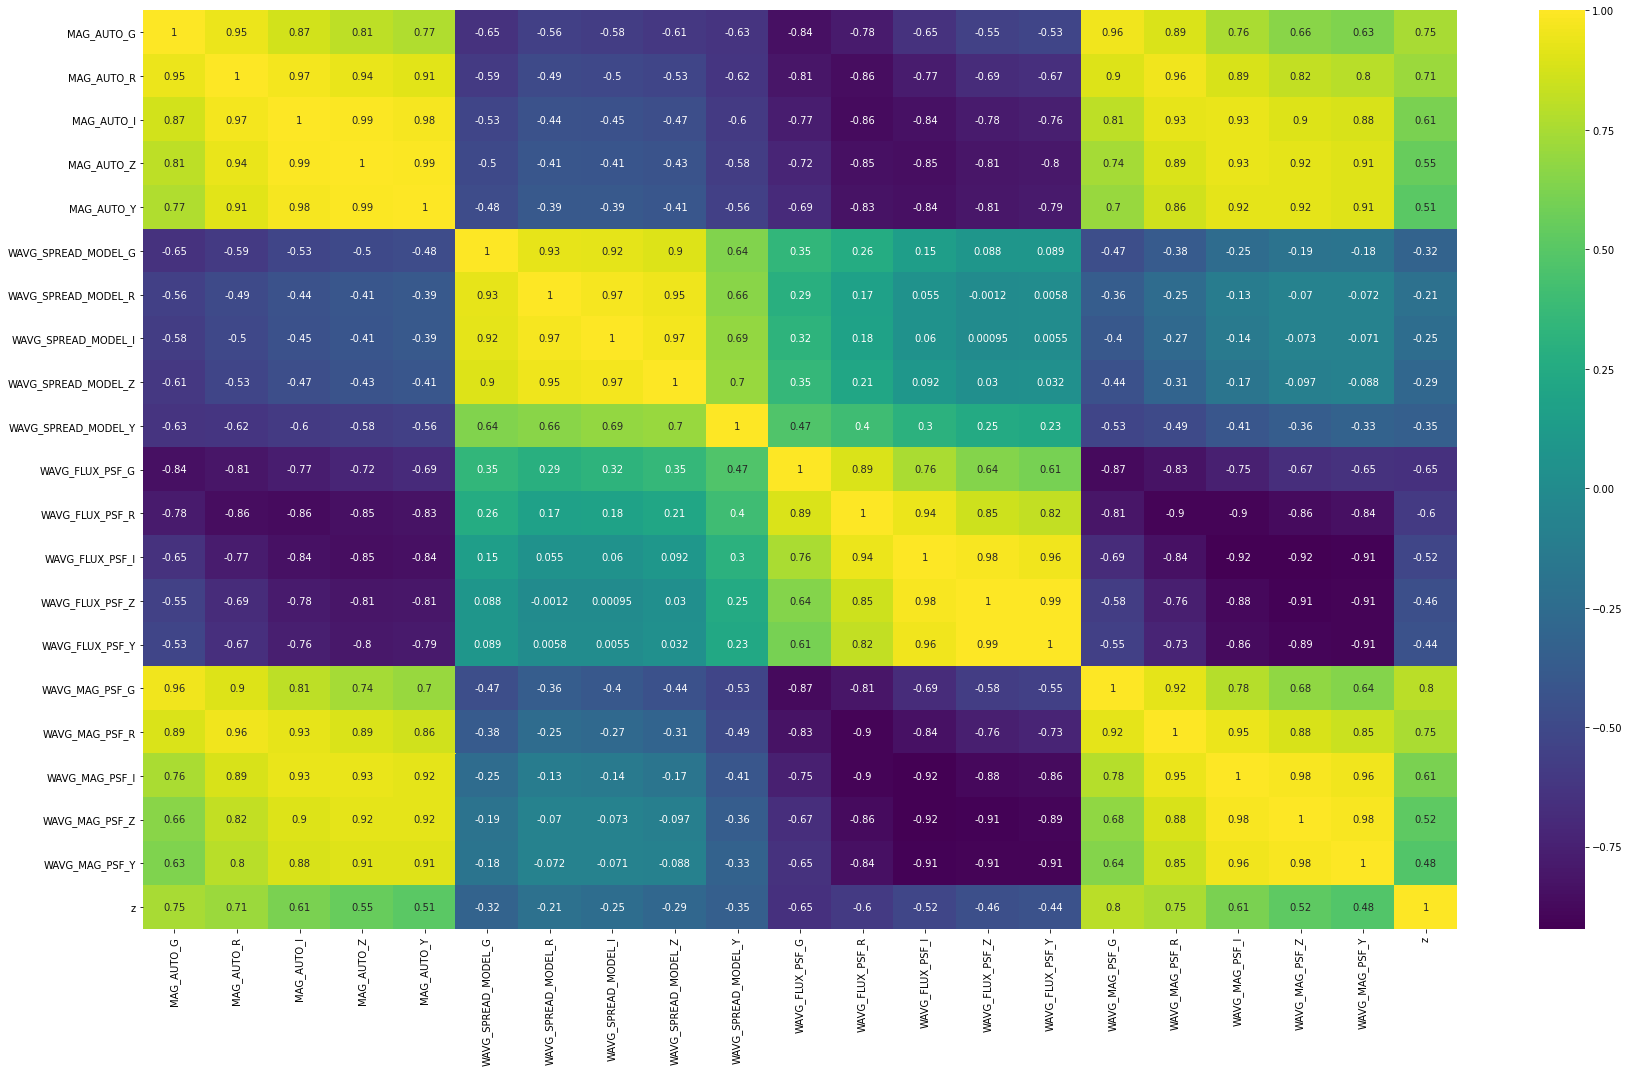

In [28]:
plt.figure(figsize=(40,32))
corrmat = vvds[feat].corr()
fig, ax = plt.subplots(figsize=(25,15))         # Sample figsize in inches
sns.heatmap(corrmat,annot=True,cmap="viridis")
plt.tight_layout()

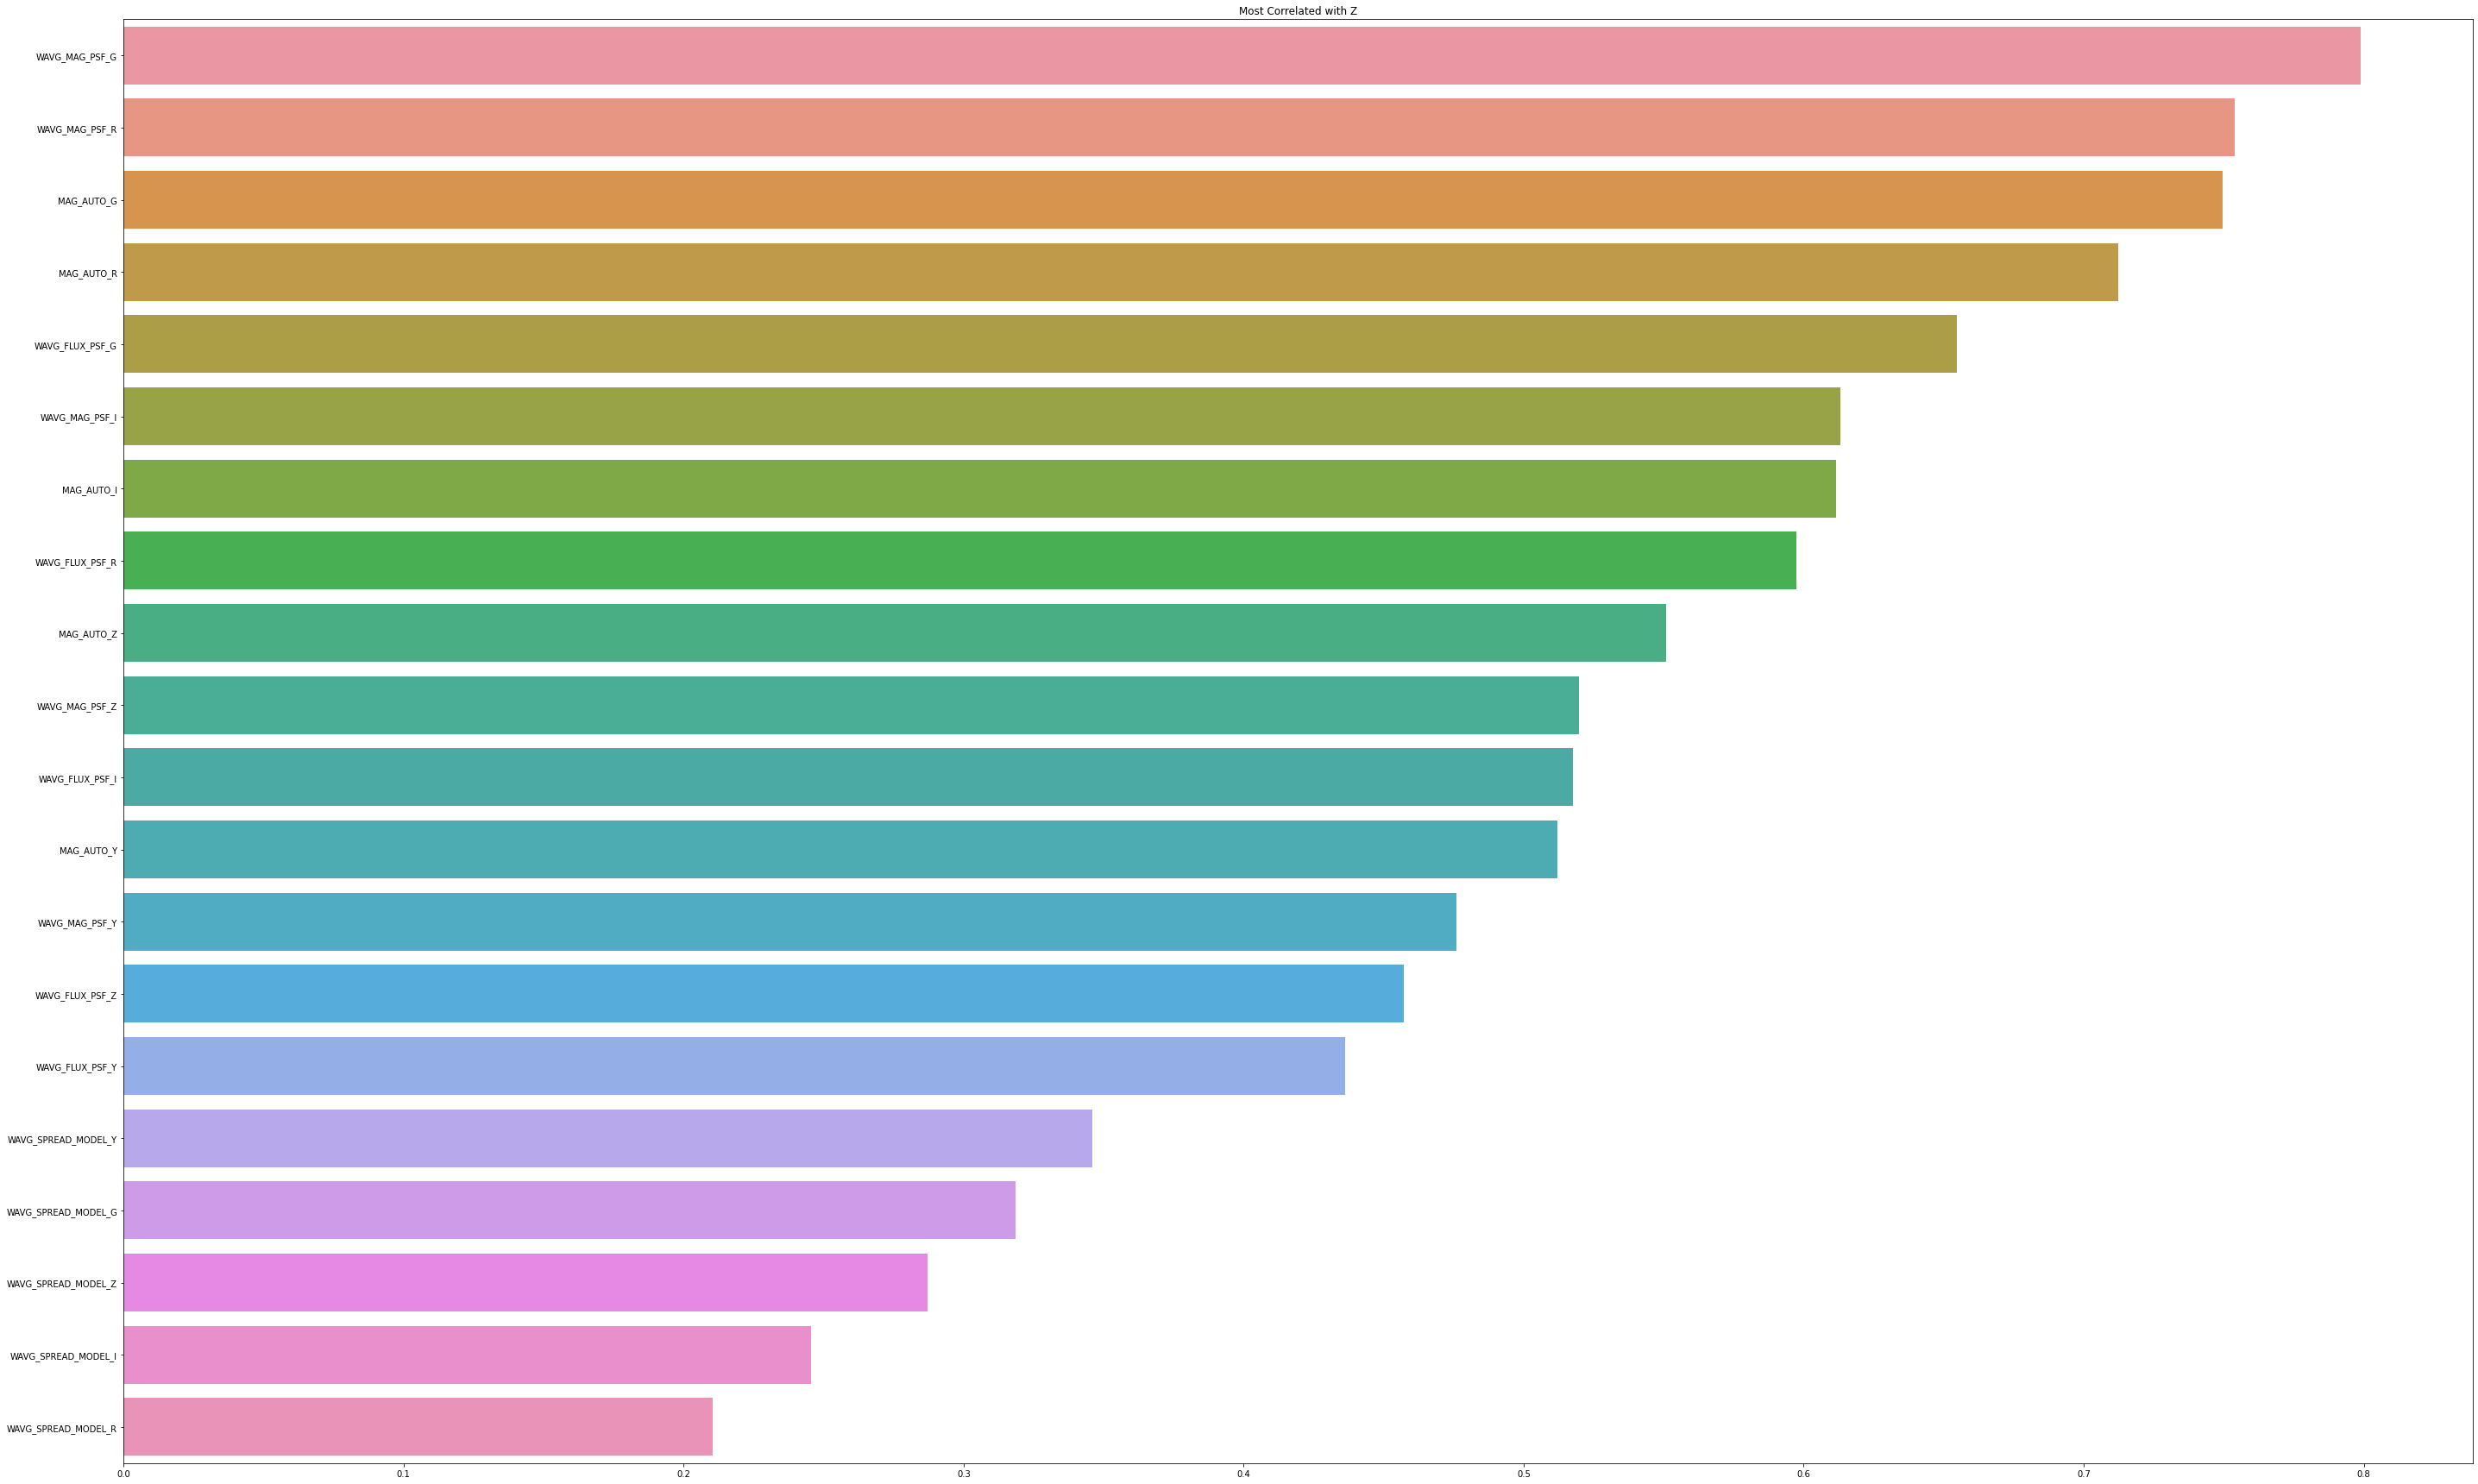

In [29]:
plt.figure(figsize=(40,24))
correlations =corrmat.abs()['z'].sort_values(ascending=False)[1:]
ax = sns.barplot(x=correlations.values,y=correlations.index).set_title('Most Correlated with Z')
plt.tight_layout()
plt.savefig("correlations.png",dpi = 500,bbox_inches = "tight" )

<Figure size 1152x576 with 0 Axes>

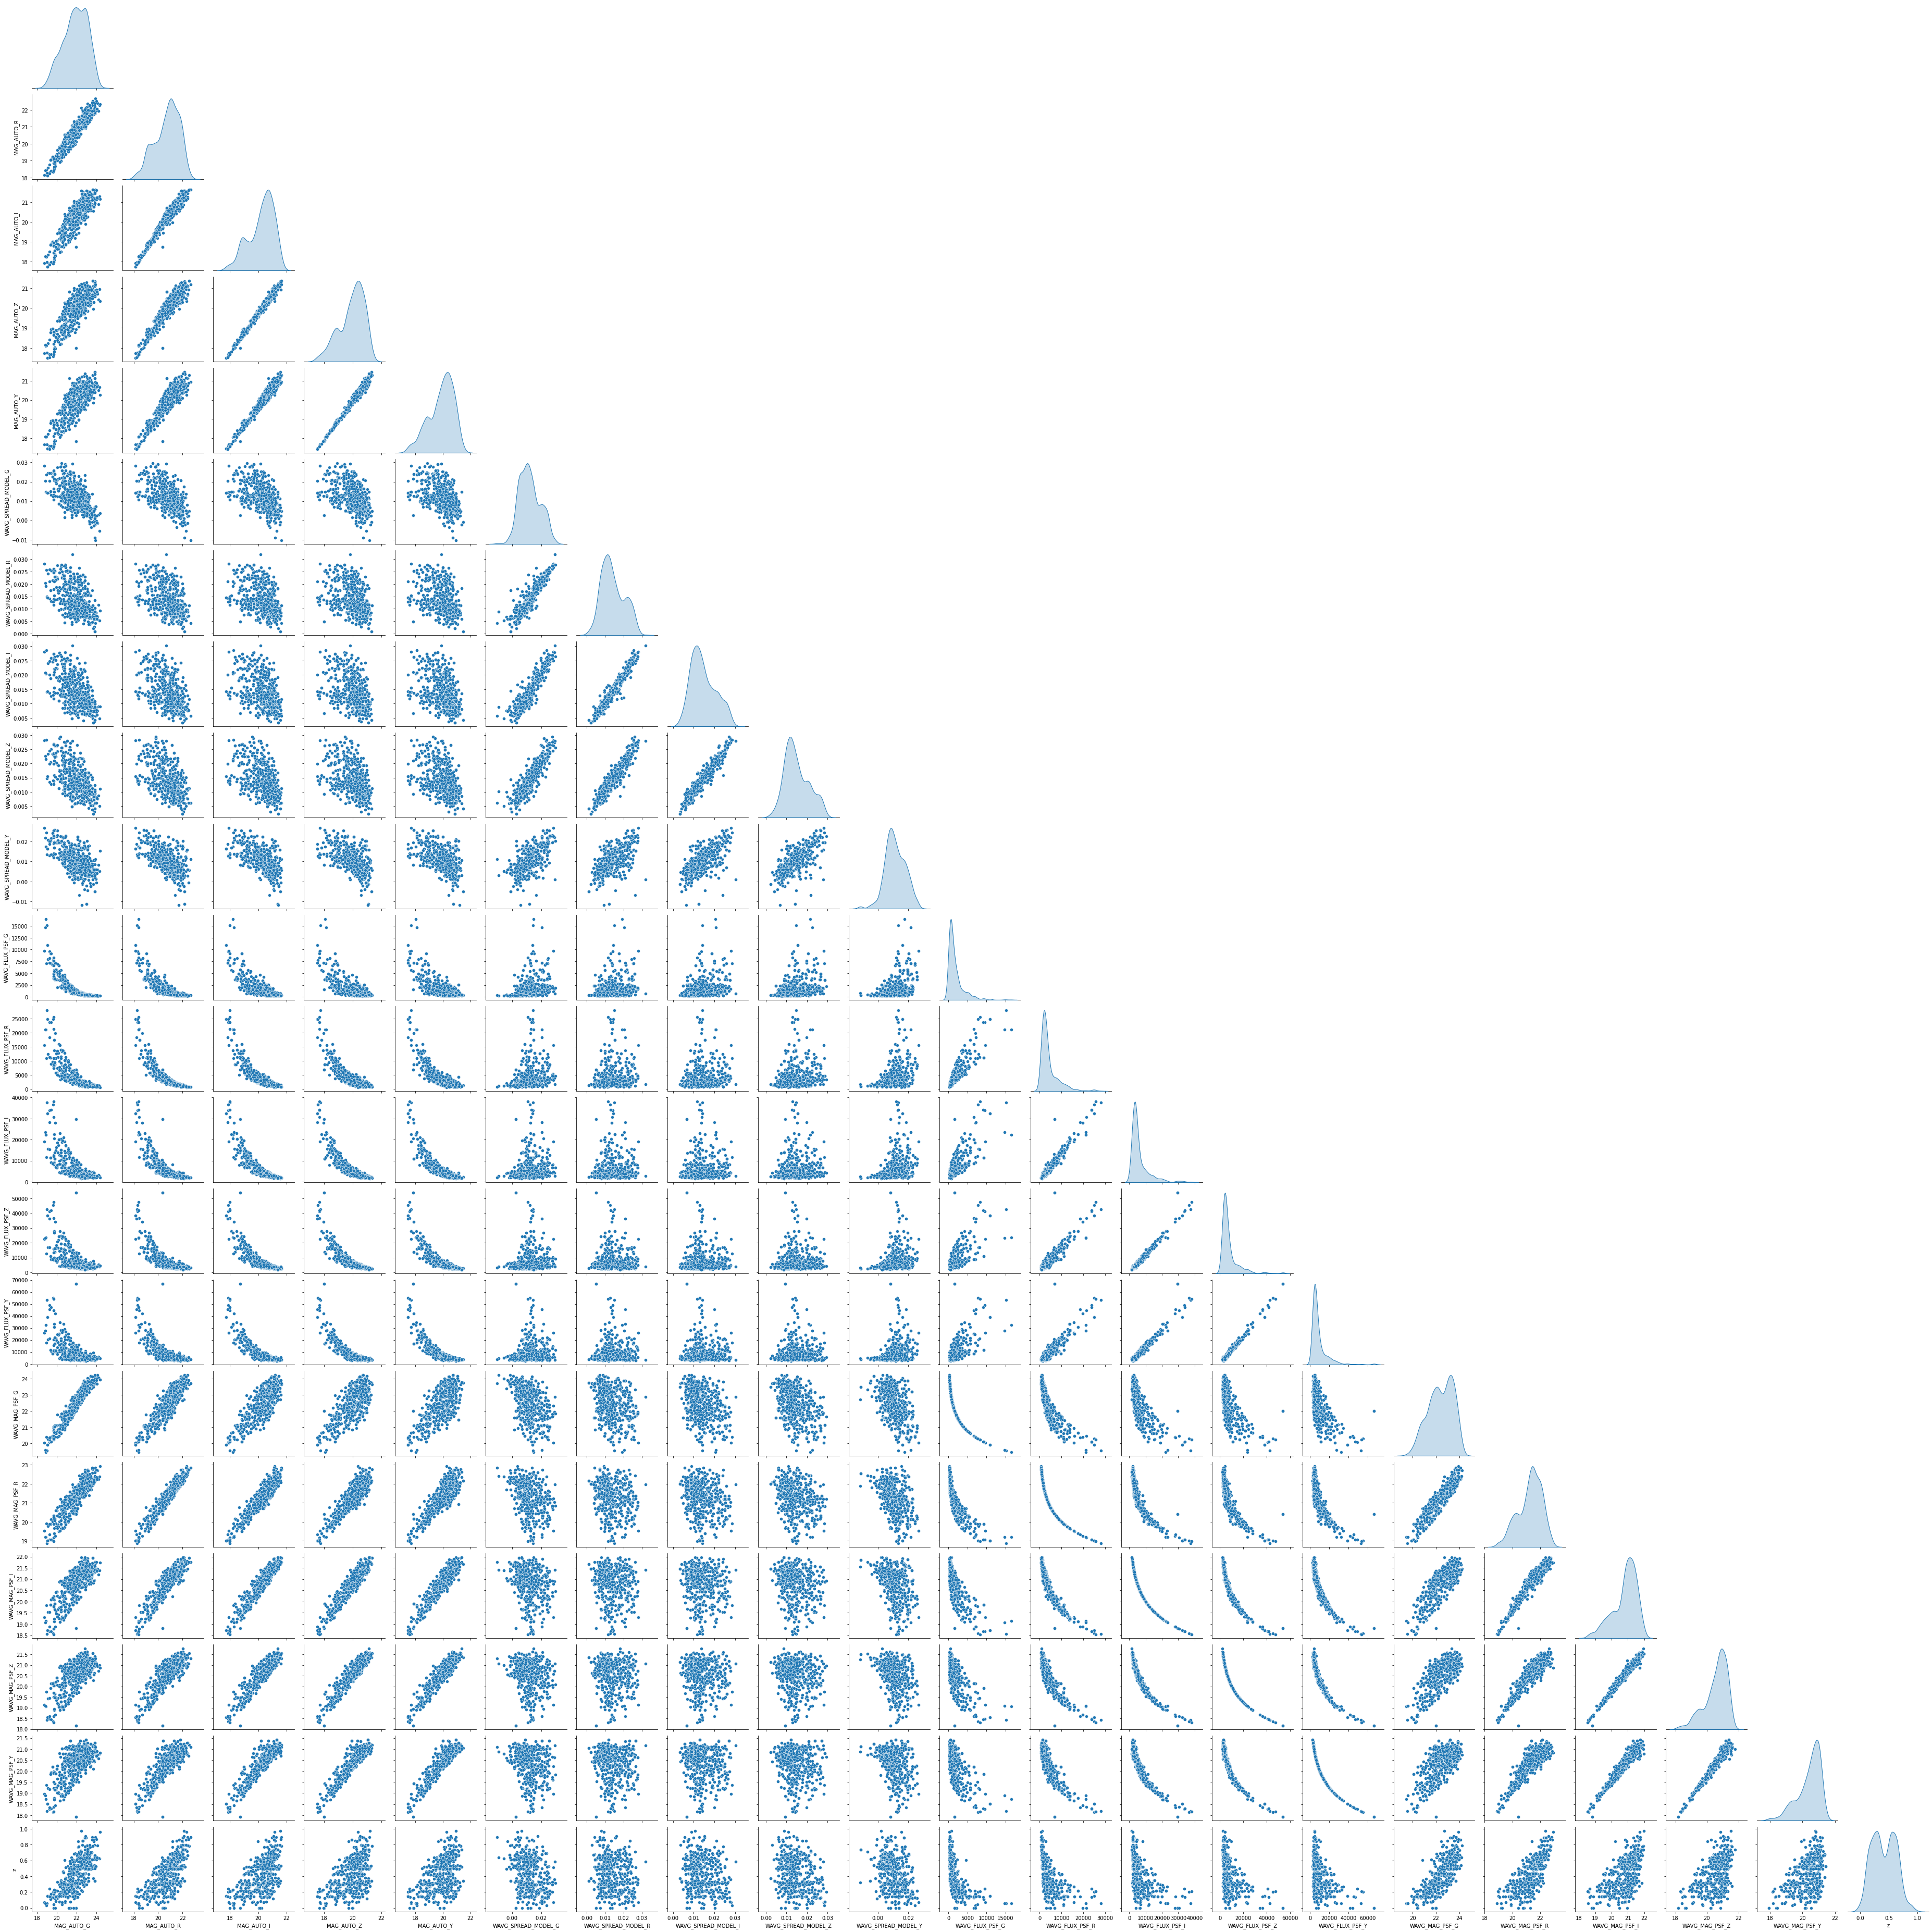

In [30]:
plt.figure(figsize=(16,8))
sns.pairplot(vvds[feat],diag_kind= "kde",corner= True)

In [31]:
pca = PCA(n_components=5)


In [32]:
new_feat = pca.fit_transform(vvds[feat])

In [33]:
corrmat = np.corrcoef(new_feat)
corrmat

array([[ 1.        , -0.95448812,  0.99399033, ...,  0.99407297,
         0.97953715,  0.97201016],
       [-0.95448812,  1.        , -0.92725024, ..., -0.91881606,
        -0.88218936, -0.98680342],
       [ 0.99399033, -0.92725024,  1.        , ...,  0.99789433,
         0.99382172,  0.95764927],
       ...,
       [ 0.99407297, -0.91881606,  0.99789433, ...,  1.        ,
         0.99521489,  0.94560975],
       [ 0.97953715, -0.88218936,  0.99382172, ...,  0.99521489,
         1.        ,  0.91988457],
       [ 0.97201016, -0.98680342,  0.95764927, ...,  0.94560975,
         0.91988457,  1.        ]])

In [34]:
corrmat.shape

(990, 990)

In [35]:
#plt.figure(figsize=(40,32))
#corrmat = np.corrcoef(new_feat)
#fig, ax = plt.subplots(figsize=(25,15))         # Sample figsize in inches
#sns.heatmap(corrmat,annot=True,cmap="viridis")
#plt.tight_layout()

## Machine Learning

In [36]:
rob_scaler1 = RobustScaler()
rob_scaler2 = RobustScaler()

In [37]:
features =['MAG_AUTO_G','MAG_AUTO_R','MAG_AUTO_I','MAG_AUTO_Z','MAG_AUTO_Y',
            "WAVG_MAG_PSF_G","WAVG_MAG_PSF_R","WAVG_MAG_PSF_I","WAVG_MAG_PSF_Z","WAVG_MAG_PSF_Y"]

X = vvds[features]
y = vvds["z"].values

X = rob_scaler1.fit_transform(X)
y = rob_scaler2.fit_transform(y.reshape(-1,1))

In [38]:
X_train, X_test,y_train, y_test = tts_split(X,y,0.3)

In [39]:
X_test[:,0].shape

(297,)

In [40]:
y_test.shape

(297, 1)

In [41]:
X_train.shape

(693, 10)

In [43]:
params_dict = {
            'KNeighborsRegressor': {'n_neighbors':list(range(3, 11))},
            'SVR' : {'kernel': ('linear', 'rbf','poly'), 'C':[1.5, 10],'gamma': [1e-7, 1e-4],'epsilon':[0.1,0.2,0.3]},
            'SGDRegressor': {'alpha': 10.0 ** -np.arange(1, 10), 'penalty': ['l2', 'l1', 'elasticnet'], 'learning_rate': ['constant', 'optimal', 'invscaling']},
            'RandomForestRegressor' : {"n_estimators": list(range(100,500,50)) ,"min_samples_split": [10, 20,30,40,50], "max_depth": [2, 6]},
            'Lasso'                 :{"max_iter": list(range(200,1000,300)),"selection" :["cyclic","random"]},
            'ElasticNet'            :{"alpha ": 10.0 ** -np.arange(1, 10),"l1_ratio" : 10.0 ** -np.arange(0, 10) ,"max_iter": list(range(200,1000,300)),"selection" :["cyclic","random"]},
            'KernelRidge'           :{'alpha': 10.0 ** -np.arange(1, 10),"degree" :[1,2,3,4,5,6,7,8,9],'coef0' : [1,2,3,4,5,6,7,8,9,]},
            'GradientBoostingRegressor' : {'loss' : ['ls', 'lad', 'huber', 'quantile'],"learning_rate": 10.0 ** -np.arange(1, 10),'n_estimators':list(range(200,1000,300)),"criterion":["friedman_mse", "mse", "mae"],"max_features":["auto","sqrt","log2"]},
  
}
            


In [44]:
KNNR = KNeighborsRegressor()
SVR = SVR()
SGDR = SGDRegressor()
RFR = RandomForestRegressor()
LAS = Lasso()
ElcNet = ElasticNet()
KRR = KernelRidge()
GBoost = GradientBoostingRegressor()
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =None, nthread = -1)


model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
#algorithms = [KNNR,SVR,SGDR,RFR,LAS,KRR,GBoost,model_xgb,model_lgb]
algorithms = [KNNR,SVR,SGDR,RFR,LAS,KRR,GBoost]

In [45]:
best_models = [] 
for algorithm in algorithms:
    clf = GridSearchCV(estimator=algorithm, param_grid=params_dict['{}'.format(algorithm.__class__.__name__)], cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    clf.fit(X_train, y_train.ravel())
    best_models.append(clf.best_estimator_)
        

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   49.0s finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 2187 out of 2187 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 972 candidates, totalling 2916 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done 2916 out of 2916 | elapsed: 34.8min finished


In [46]:
evaluation = []
for model in best_models:
    predictions = model.predict(X_test)
    evaluation.append(mean_squared_error(y_test, predictions))

In [47]:
evaluation

[0.072088696,
 0.1044077036723103,
 0.11506441642025891,
 0.05879399099646962,
 0.34631490249529995,
 0.11206268755033731,
 0.047068553299060796]

We search the best ML models, using the GridSearch, for this we compute the **Mean Squared ERROR**. 

As we can see from the evalutions the best models is


We now see the **XGboost** and **LGBMRegressor**

In [48]:
model_xgb.fit(X_train,y_train)
predictions = model_xgb.predict(X_test)
evaluation.append(mean_squared_error(y_test, predictions))
evaluation[-1]

[09:01:39] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




0.048121173

In [49]:
model_lgb.fit(X_train,y_train.ravel())
predictions = model_lgb.predict(X_test)
evaluation.append(mean_squared_error(y_test, predictions))
evaluation[-1]

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


0.05028431673739371

In [50]:
print("Best Models for is :\n",algorithms[0],"\n",algorithms[3],"\n",algorithms[-1])

Best Models for is :
 KNeighborsRegressor() 
 RandomForestRegressor() 
 GradientBoostingRegressor()


## Less simple Stacking : Adding a Meta-model

In this approach, we add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model. 

The procedure, for the training part, may be described as follows:


1. Split the total training set into two disjoint sets (here **train** and .**holdout** )

2. Train several base models on the first part (**train**)

3. Test these base models on the second part (**holdout**)

4. Use the predictions from 3)  (called  out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs  to train a higher level learner called **meta-model**.

The first three steps are done iteratively . If we take for example a 5-fold stacking , we first split the training data into 5 folds. Then we will do 5 iterations. In each iteration,  we train every base model on 4 folds and predict on the remaining fold (holdout fold). 

So, we will be sure, after 5 iterations , that the entire data is used to get out-of-folds predictions that we will then use as 
new feature to train our meta-model in the step 4.

For the prediction part , We average the predictions of  all base models on the test data  and used them as **meta-features**  on which, the final prediction is done with the meta-model.


![Faron](http://i.imgur.com/QBuDOjs.jpg)

(Image taken from [Faron](https://www.kaggle.com/getting-started/18153#post103381))

![kaz](http://5047-presscdn.pagely.netdna-cdn.com/wp-content/uploads/2017/06/image5.gif)

Gif taken from [KazAnova's interview](http://blog.kaggle.com/2017/06/15/stacking-made-easy-an-introduction-to-stacknet-by-competitions-grandmaster-marios-michailidis-kazanova/)

On this gif, the base models are algorithms 0, 1, 2 and the meta-model is algorithm 3. The entire training dataset is 
A+B (target variable y known) that we can split into train part (A) and holdout part (B). And the test dataset is C. 

B1 (which is the prediction from the holdout part)  is the new feature used to train the meta-model 3 and C1 (which
is the prediction  from the test dataset) is the meta-feature on which the final prediction is done. 

In [53]:
from ml_functions import StackingAveragedModels

In [54]:
stacked_averaged_models = StackingAveragedModels(base_models = (RFR, GBoost, KNNR),
                                                 meta_model = SVR,n_folds = 5)



In [55]:
stacked_averaged_models.fit(X_train,y_train.ravel())
predictions = stacked_averaged_models.predict(X_test)
mean_squared_error(y_test, predictions)

0.05099627708604552

In [56]:
score = rmsle_cv(stacked_averaged_models,X_train,y_train)

print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.2281 (0.0366)


In [57]:
stacked_averaged_models.fit(X_train, y_train.ravel())
stacked_train_pred = stacked_averaged_models.predict(X_train)
stacked_pred = np.expm1(stacked_averaged_models.predict(X_test))
print(rmsle(y_train, stacked_train_pred))
print("\n",mean_squared_error(y_train, stacked_train_pred))

0.12527543588954299

 0.015693934837314995


In [58]:
model_xgb.fit(X_train, y_train.ravel())
xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = np.expm1(model_xgb.predict(X_test))
print(rmsle(y_train, xgb_train_pred))
print("\n",mean_squared_error(y_train, xgb_train_pred))

[09:04:43] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.09831382

 0.0096656075


In [59]:
model_lgb.fit(X_train, y_train)
lgb_train_pred = model_lgb.predict(X_train)
lgb_pred = np.expm1(model_lgb.predict(X_test))
print(rmsle(y_train, lgb_train_pred))
print("\n",mean_squared_error(y_train, lgb_train_pred))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/home/rafael/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.14340896927565774

 0.02056613246870655


In [60]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

print('\nMSE score on train data:')

print(mean_squared_error(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))


RMSLE score on train data:
0.11846830876927393

MSE score on train data:
0.014034740182652028


In [61]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [62]:
ensemble = rob_scaler2.inverse_transform(ensemble.reshape(-1,1))
y_original = rob_scaler2.inverse_transform(y_test)
ensemble[:5]

array([[0.49691142],
       [0.33576038],
       [0.3928892 ],
       [0.6036698 ],
       [0.38330061]])

In [63]:
print('RMSE score on test data:')
print(rmsle(y_original,ensemble))

print('\nMSE score on test data:')

print(mean_squared_error(y_original,ensemble))


RMSE score on test data:
0.11634606905073315

MSE score on test data:
0.013536407783557965


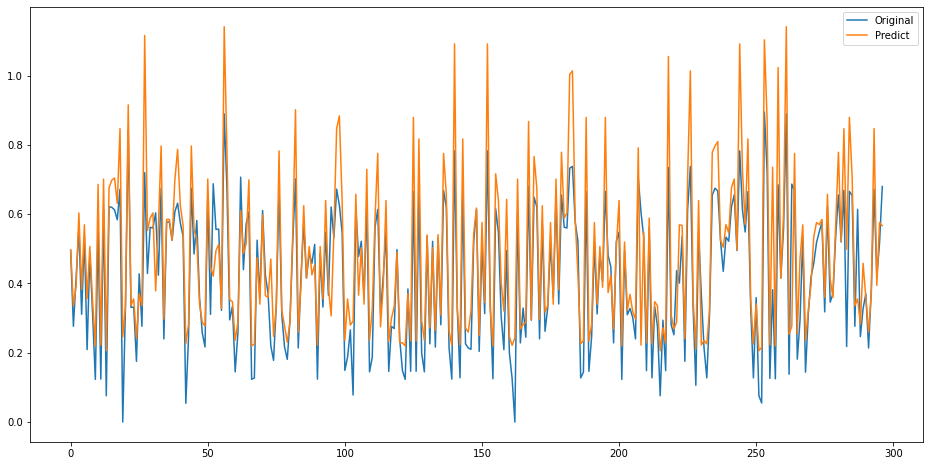

In [64]:
plt.figure(figsize=(16,8))
plt.plot(y_original,label = "Original")
plt.plot(ensemble,label = "Predict")
plt.legend()

In [65]:
n_inputs = X_train.shape[1]
ann_model = Sequential([Dense(n_inputs,input_shape = X_train.shape[1:],kernel_initializer='normal', activation='selu'),
                       
                       Dropout(0.05),
                       Dense(25, kernel_initializer='normal', activation='selu'),
                       
                       Dense(25,kernel_initializer='normal', activation='selu') ,
                       Dense(1,activation = None,name = "output")
                       ])

In [66]:
ann_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                275       
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
output (Dense)               (None, 1)                 26        
Total params: 1,061
Trainable params: 1,061
Non-trainable params: 0
_________________________________________________________________


In [67]:
cp_path = home+'/PHOTOzxcorr/notebooks/Checkpoint/cp.ckpt'
cp = ModelCheckpoint(cp_path,
                     save_best_only=True,
                     save_weights_only=True,
                     verbose=False,
                     save_freq='epoch',
                     monitor='val_loss',
                     mode='min')

In [68]:
EarlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=20)

In [69]:
opt = ks.optimizers.Adam(lr=0.001, decay=5e-4)
#opt = tf.keras.optimizers.RMSprop(0.001)
ann_model.compile(optimizer=opt, loss=rmse_ann, metrics=['mse', 'mae', 'mape',rmse_ann])

In [70]:
history = ann_model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.1, callbacks=[cp])
#history = ann_model.fit(X_train, y_train, epochs=1000, batch_size=16, validation_split=0.1, callbacks=[cp, EarlyStop])

Epoch 1/1000
20/20 [==============================] - 0s 18ms/step - loss: 0.4568 - mse: 0.2914 - mae: 0.4568 - mape: 305705.0312 - rmse_ann: 0.4568 - val_loss: 0.3619 - val_mse: 0.1926 - val_mae: 0.3619 - val_mape: 6164751.0000 - val_rmse_ann: 0.3619
Epoch 2/1000
20/20 [==============================] - 0s 5ms/step - loss: 0.3462 - mse: 0.1831 - mae: 0.3462 - mape: 239664.8438 - rmse_ann: 0.3462 - val_loss: 0.2737 - val_mse: 0.1312 - val_mae: 0.2737 - val_mape: 2357548.2500 - val_rmse_ann: 0.2737
Epoch 3/1000
20/20 [==============================] - 0s 6ms/step - loss: 0.2844 - mse: 0.1428 - mae: 0.2844 - mape: 259022.4375 - rmse_ann: 0.2844 - val_loss: 0.2118 - val_mse: 0.0745 - val_mae: 0.2118 - val_mape: 2480328.2500 - val_rmse_ann: 0.2118
Epoch 4/1000
20/20 [==============================] - 0s 5ms/step - loss: 0.2643 - mse: 0.1314 - mae: 0.2643 - mape: 90755.5469 - rmse_ann: 0.2643 - val_loss: 0.1944 - val_mse: 0.0716 - val_mae: 0.1944 - val_mape: 292437.4688 - val_rmse_ann: 0.19

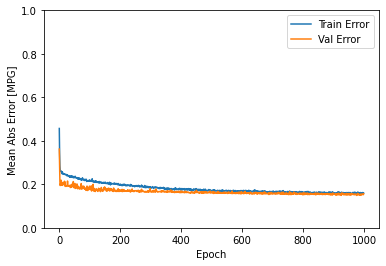

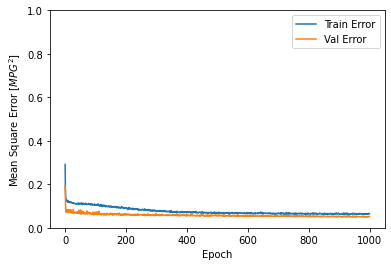

In [71]:
plot_history(history)

In [72]:
loss, mae, mse,mape,rmse_ann = ann_model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

10/10 [==============================] - 0s 975us/step - loss: 0.1729 - mse: 0.0769 - mae: 0.1729 - mape: 176133.8438 - rmse_ann: 0.1729
Testing set Mean Abs Error:  0.08 MPG


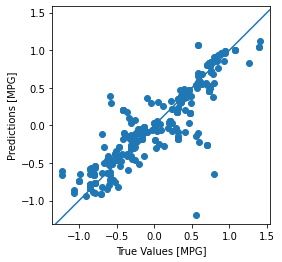

In [73]:
test_predictions = ann_model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


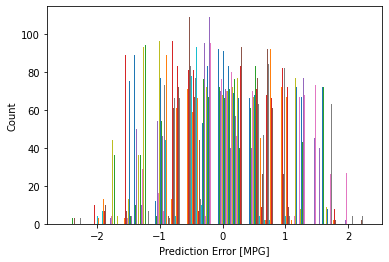

In [74]:
error = test_predictions - y_test
plt.hist(error)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

Now we gonna use the this pre-trained model, to try a improvoment

In [75]:
# Loads the weights
ann_model.load_weights(cp_path)

# Re-evaluate the model
loss, mae, mse,mape,rmse_ann = ann_model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
#print("Restored model, accuracy: {:5.2f}%".format(100 * mae))

10/10 [==============================] - 0s 1ms/step - loss: 0.1743 - mse: 0.0782 - mae: 0.1743 - mape: 85481.9531 - rmse_ann: 0.1743
Testing set Mean Abs Error:  0.08 MPG


In [76]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = home+"/PHOTOzxcorr/notebooks/Checkpoint/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 16

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)

# Create a new model instance
# model = create_model()

# Save the weights using the `checkpoint_path` format
ann_model.save_weights(checkpoint_path.format(epoch=0))
## New optimizer
opt_new = tf.keras.optimizers.Adamax(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")

ann_model.compile(optimizer=opt_new, loss = "mse", metrics=['mse', 'mae', 'mape'])
# Train the model with the new callback
ann_model.fit(X_train, 
          y_train,
          epochs=1000,
          batch_size = 32,
          callbacks=[cp_callback],
          validation_data=(X_test, y_test))

Epoch 1/1000
22/22 [==============================] - 0s 7ms/step - loss: 0.0712 - mse: 0.0712 - mae: 0.1848 - mape: 309338.6250 - val_loss: 0.0767 - val_mse: 0.0767 - val_mae: 0.1741 - val_mape: 70861.8672
Epoch 2/1000
22/22 [==============================] - 0s 2ms/step - loss: 0.0626 - mse: 0.0626 - mae: 0.1644 - mape: 256440.2500 - val_loss: 0.0768 - val_mse: 0.0768 - val_mae: 0.1788 - val_mape: 25162.2090
Epoch 3/1000
22/22 [==============================] - 0s 2ms/step - loss: 0.0640 - mse: 0.0640 - mae: 0.1695 - mape: 99303.3438 - val_loss: 0.0760 - val_mse: 0.0760 - val_mae: 0.1752 - val_mape: 214987.4531
Epoch 4/1000
 1/22 [>.............................] - ETA: 0s - loss: 0.0508 - mse: 0.0508 - mae: 0.1674 - mape: 228.5066
Epoch 00004: saving model to /home/rafael/PHOTOzxcorr/notebooks/Checkpoint/cp-0004.ckpt
22/22 [==============================] - 0s 3ms/step - loss: 0.0612 - mse: 0.0612 - mae: 0.1633 - mape: 160911.8906 - val_loss: 0.0742 - val_mse: 0.0742 - val_mae: 0.174

In [77]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'/home/rafael/PHOTOzxcorr/notebooks/Checkpoint/cp-1000.ckpt'

In [78]:
# Load the previously saved weights
ann_model.load_weights(latest)

# Re-evaluate the model
loss, mae, mse,mape, = ann_model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
#print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

10/10 [==============================] - 0s 1ms/step - loss: 0.0513 - mse: 0.0513 - mae: 0.1550 - mape: 463621.5938
Testing set Mean Abs Error:  0.05 MPG


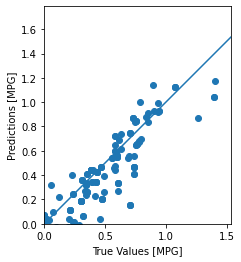

In [79]:
test_predictions = ann_model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


In [80]:
error = rmsle(y_test,test_predictions)
print("Testing set Mean Abs Error: ",error, " RMSE")

Testing set Mean Abs Error:  0.2265674  RMSE


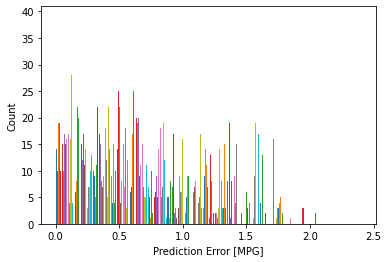

In [81]:
error = np.abs(test_predictions - y_test)
plt.hist(error,bins = 50)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

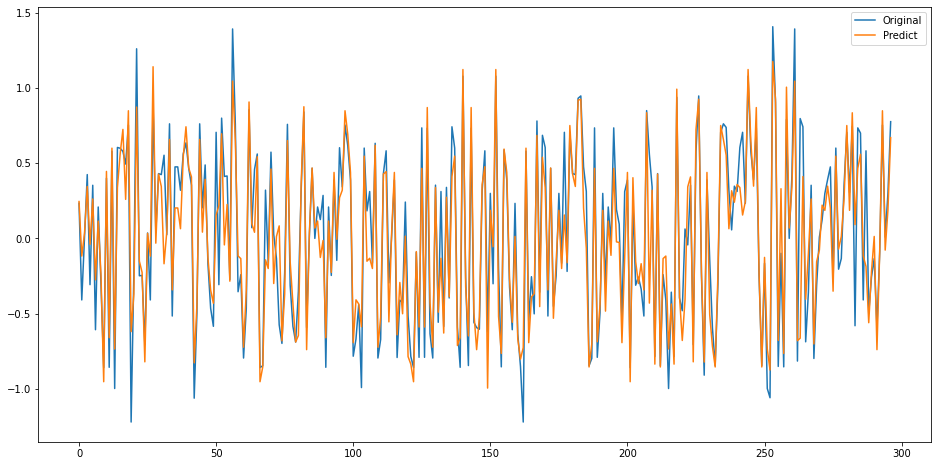

In [82]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label = "Original")
plt.plot(test_predictions,label = "Predict")
plt.legend()

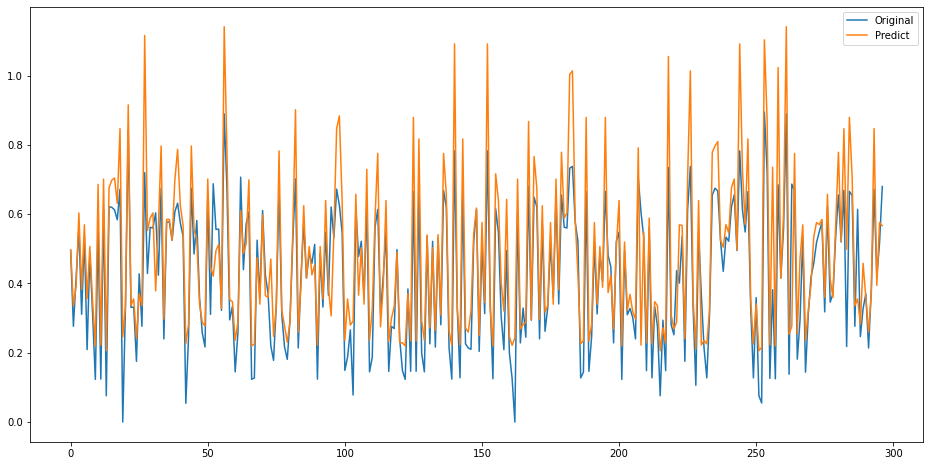

In [83]:
y_original = rob_scaler2.inverse_transform(y_test)
plt.figure(figsize=(16,8))
plt.plot(y_original,label = "Original")
plt.plot(ensemble,label = "Predict")
plt.legend()

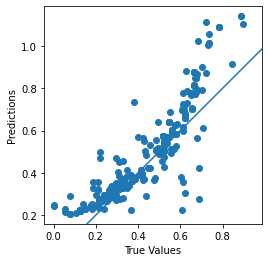

In [84]:

plt.scatter(y_original, ensemble)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


In [85]:
rob_scaler3 = RobustScaler()

In [86]:
x_true = rob_scaler3.fit_transform(des[features])
z = ann_model.predict(x_true)
z_true = rob_scaler2.inverse_transform(z)
des["z"] = z_true


In [87]:
stacked_pred = np.expm1(stacked_averaged_models.predict(x_true))
lgb_pred = np.expm1(model_lgb.predict(x_true))
xgb_pred = np.expm1(model_xgb.predict(x_true))
ensamble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15
ensamble = rob_scaler2.inverse_transform(ensamble.reshape(-1,1))
des["z_1"] = ensamble

In [88]:
des[["z","z_1"]]

z       z_1
0       2.453445  0.332451
1       0.716391  0.971882
2       0.568796  0.886729
3       0.469655  0.533486
4       0.319975  0.715469
...          ...       ...
163345  0.426725  0.518553
163346  0.339167  0.475164
163347  5.195610  0.764872
163348  2.497095  0.430497
163349  0.600237  0.993660

[163350 rows x 2 columns]